# 1. Pose Estimation

## 1.1. Getting Features and Targets

**Parsing xml annotation files**. Make sure the pose annotation files are in CVAT XML 1.1 for videos format and are located in the folder `data_rf/annotations/`. The annotation and video filenames should match.

In [2]:
from utils import *

annotation_parser = AnnotationParser()
base_path = "../data_rf"
video_names = ["VID_20200325_172105.mp4","VID_20200320_191355.mp4","VID_20200325_171448.mp4"]

annotations_df = pd.DataFrame({})
for video_name in video_names:
    video_path = "{}/videos/{}".format(base_path,video_name)
    annotation_path = "{}/annotations/{}.xml".format(base_path,video_name.split('.')[0])
    annotation_df = annotation_parser.parse(annotation_file_name=annotation_path)
    annotation_df = annotation_df.loc[annotation_df['activity']!='none']
    annotation_df["video_name"]=video_name
    annotations_df = annotations_df.append(annotation_df)
    
data_names_df = pd.DataFrame(annotations_df.set_index(["video_name","frame"]).index.unique())
data_names_df = data_names_df.apply(lambda x: pd.Series({"video_name":x[0][0],"frame":x[0][1]}),axis=1)
print("{} video frames annotated for pose estimation".format(data_names_df.shape[0]))
data_names_df.head()

**Cropping people from video frames.** It is saving cropped images in folder `data_rf/images/`. It may be very time consuming, that is why the cutting flag is set to False, set it to True only if necessary.

In [11]:
import json
import os

t0 = time()
cutting_flag = False # Change This for cutting
if cutting_flag:
    cutting_details = []
    dest_path = "{}/images".format(base_path)
    if not os.path.exists(dest_path):
        print("Creating directory {}".format(dest_path))
        os.makedirs(dest_path)
    for video_name in data_names_df['video_name'].unique():
        frame_counters = data_names_df.set_index('video_name').loc[video_name,'frame'].values
        frame_extractor = FrameExtractor("{}/videos/{}".format(base_path,video_name))
        img_prefix = video_name.split('.')[0]
        cutting_details.append(frame_extractor.extract_person_from_frame_list(frame_counters=frame_counters,
                                                                              img_name=img_prefix, dest_path=dest_path))
    cutting_details_df = pd.DataFrame(list(np.hstack(cutting_details)))
    cutting_details_df.to_csv('{}/cutting_details.csv'.format(base_path),index=False)
else:
    cutting_details_df = pd.read_csv('{}/cutting_details.csv'.format(base_path))
    cutting_details_df['cutting_rect'] = cutting_details_df['cutting_rect'].apply(json.loads)
print('total_time {}'.format(time()-t0))

total_time 0.17080378532409668


## 1.2. Simple Baselines Model

**Setting up the simple baselines model architecture.** The pose estimation model follows most of the [[Xiao-18]](https://arxiv.org/pdf/1804.06208.pdf) gidelines for pose estimation (no optical flow implemented yet).

In [9]:
%matplotlib inline

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

from PIL import Image
from sklearn.utils import shuffle
from keras import optimizers, applications
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import Conv2DTranspose, BatchNormalization
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard, CSVLogger
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

img_height, img_width = (256,192)
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))

output = base_model.output
output = Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2), activation='relu')(output)
output = BatchNormalization()(output)
output = Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2), activation='relu')(output)
output = BatchNormalization()(output)
output = Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2), activation='relu')(output)
output = BatchNormalization()(output)
output = Conv2D(filters=8, kernel_size=1, activation='linear')(output)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

/home/jchaconl/ensc813-project/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 192, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 198, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 96, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 96, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

**Trainning with data augmentation.** Setting up the image data generators, callbacks used for training and performing training.

In [14]:
from sklearn.model_selection import train_test_split
data_names = data_names_df.apply(lambda x:"{}_{}.jpg".format(x['video_name'].split('.')[0],x['frame']),axis=1).values
list_IDs_train, list_IDs_test = train_test_split(data_names, test_size=0.15,random_state=0)
batch_size = 32
# Train iterator
image_data_generator_params ={
    "featurewise_center":True,
    "featurewise_std_normalization":True,
    "rotation_range":5,
    "width_shift_range":0.1,
    "height_shift_range":0,
    "horizontal_flip":True}
iterator_params = {'dim_input': (256, 192),
                   'dim_output': (78, 62),
                   'batch_size': batch_size,
                   'n_channels_input': 3,
                   'n_channels_output': 8,
                   'shuffle': True}
path_to_images='../data_rf/images/'
train_iterator = PoseIterator(list_IDs_train, annotations_df, cutting_details_df, path_to_images, 
                 batch_size=32,dim_input=(256, 192), dim_output=(78, 62), n_channels_input=3, 
                 n_channels_output=8, shuffle=True, seed=0, **image_data_generator_params)
# Validation iterator
image_data_generator_params ={}
iterator_params = {'dim_input': (256, 192),
                   'dim_output': (78, 62),
                   'batch_size': batch_size,
                   'n_channels_input': 3,
                   'n_channels_output': 8,
                   'shuffle': True}
path_to_images='../data_rf/images/'
validation_iterator = PoseIterator(list_IDs_test, annotations_df, cutting_details_df, path_to_images, 
                 batch_size=32,dim_input=(256, 192), dim_output=(78, 62), n_channels_input=3, 
                 n_channels_output=8, shuffle=True, seed=0, **image_data_generator_params)

# Setting up Callbacks
filepath = "checkpoints/simple_baseline_weights-{epoch:02d}-{loss:.8f}-{val_loss:.8f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)
csv_logger = CSVLogger('logs/training.log')
tensor_board = TensorBoard(log_dir='logs', update_freq='epoch')
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15,mode='min', min_lr=1e-6)
def scheduler(epoch):
    if epoch < 10:
        return 1e-4
    elif epoch < 15:
        return 1e-5
    else:
        return 1e-6

lr_scheduler = LearningRateScheduler(scheduler)
callbacks = [checkpoint, early_stop, reduce_lr_on_plateau, tensor_board, csv_logger]

history = model.fit_generator(generator=train_iterator, steps_per_epoch=20000 // batch_size,
                              validation_data=validation_iterator, validation_steps=400 // batch_size,
                              use_multiprocessing=True, workers=6, epochs=1, callbacks=callbacks)

# plotting Learning curves
df = pd.read_csv('logs/training.log')
fig,ax = plt.subplots(figsize=(8,6))
ax.semilogy(df[['loss','val_loss']].values);
ax.grid()
ax.legend(['Train loss','Validation loss'],fontsize=14)
ax.set_xlabel('Epoch',fontsize=16)
ax.set_ylabel(r'$\ell_{2}$ loss',fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax2=ax.twinx()
ax2.semilogy(df[['lr']].values,color='red')
ax2.set_ylabel('learing rate',color='red',fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
fig.savefig('figs/train_results.png')

Epoch 1/1
625/625 [==============================] - 345s 553ms/step - loss: 0.0309 - val_loss: 5.7675e-04

Epoch 00001: val_loss improved from inf to 0.00058, saving model to checkpoints/simple_baseline_weights-01-0.03089384-0.00057675.h5


W0404 16:52:12.032043 47347463937728 module_wrapper.py:139] From /home/jchaconl/ensc813-project/lib/python3.6/site-packages/keras/callbacks.py:995: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



**Only Inference for new Images**

In [8]:
load_existing_model = False
if load_existing_model:
    model.load_weights('checkpoints/simple_baseline_weights-47-0.00001083-0.00003969.h5')

Parsing ../darkflow/cfg/yolov2-tiny.cfg
Loading ../darkflow/bin/yolov2-tiny.weights ...
Successfully identified 44948600 bytes
Finished in 0.014272928237915039s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Loa

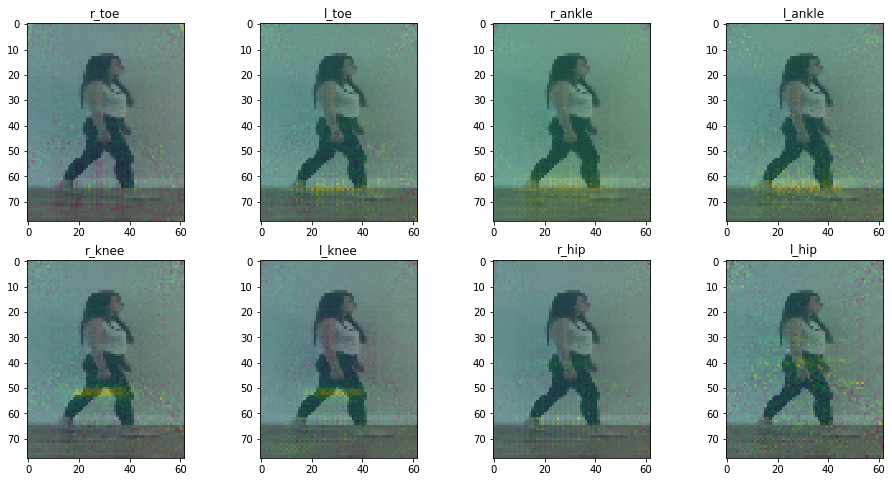

In [22]:
base_path = "../data_rf/images"
filename = "testing.png"
image_path = "{}/{}".format(base_path, filename) # New Image path
imgcv = cv2.imread(image_path)

# Preprocesing input X
yolo_detector = Yolo()
X, width_scale, height_scale, cutting_rect = yolo_detector.extract_person(imgcv)
X = cv2.cvtColor(img_to_array(X)/255, cv2.COLOR_BGR2RGB)
X = np.expand_dims(X, axis=0)

# Model Prediction
y_pred = model.predict(X)

# Plotting Results
ORDERED_LABELS = ['r_toe','l_toe','r_ankle','l_ankle','r_knee','l_knee','r_hip','l_hip']
f, ax = plt.subplots(2,4,figsize=(16,8))
XX = cv2.resize(X[0,:,:,:], dsize=(62,78), interpolation=cv2.INTER_CUBIC)
for joint_ind in range(8):
    ax[joint_ind//4][joint_ind%4].imshow(XX)
    ax[joint_ind//4][joint_ind%4].imshow(y_pred[0,:,:,joint_ind],alpha=0.4)
    ax[joint_ind//4][joint_ind%4].set_title('{}'.format(ORDERED_LABELS[joint_ind]))
plt.show()

**Inference and Decoding Predictions for new Images**

In [8]:
load_existing_model = False
if load_existing_model:
    model.load_weights('checkpoints/simple_baseline_weights-47-0.00001083-0.00003969.h5')

Parsing ../darkflow/cfg/yolov2-tiny.cfg
Loading ../darkflow/bin/yolov2-tiny.weights ...
Successfully identified 44948600 bytes
Finished in 0.015011787414550781s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Loa

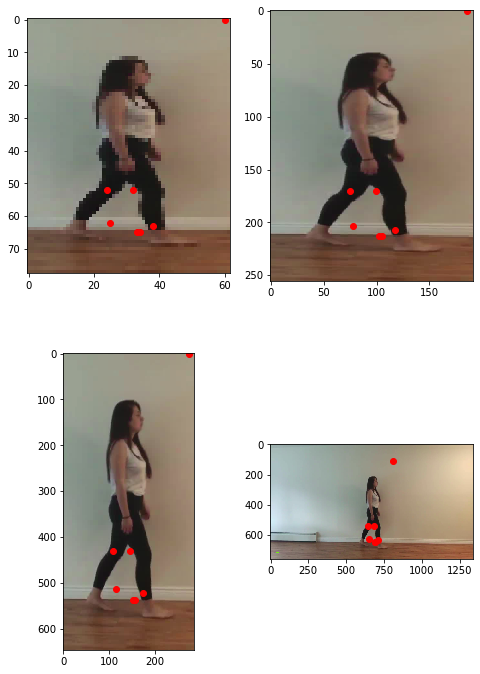

In [23]:
base_path = "../data_rf/images"
filename = "testing.png"
image_path = "{}/{}".format(base_path, filename)
imgcv = cv2.imread(image_path)

yolo_detector = Yolo()
X, width_scale, height_scale, cutting_rect = yolo_detector.extract_person(imgcv)
X = cv2.cvtColor(img_to_array(X)/255, cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(2,2,figsize=(8,12))
XX = cv2.resize(X, dsize=(62,78), interpolation=cv2.INTER_CUBIC)

for joint_ind in range(7):
    coords = np.where(y_pred==np.max(y_pred[0,:,:,joint_ind]))
    coords_0 = [coord[0] for coord in coords][1:3]
    coords_1 = np.dot(np.diag([256/78,192/62]),coords_0)
    coords_2 = np.dot(np.diag([1/height_scale,1/width_scale]),coords_1).astype(int)
    coords_3 = [cutting_rect[1]+coords_2[0],cutting_rect[0]+coords_2[1]]
    # Resolution 78 x 62
    ax[0][0].imshow(XX)
    ax[0][0].plot(coords_0[1],coords_0[0],'ro')
    # Resolution 256 x 192
    ax[0][1].imshow(X)
    ax[0][1].plot(coords_1[1],coords_1[0],'ro')
    # Original Resolution
    ax[1][0].imshow(cv2.cvtColor(img_to_array(array_to_img(imgcv).crop(cutting_rect)),cv2.COLOR_BGR2RGB)/255)
    ax[1][0].plot(coords_2[1],coords_2[0],'ro')
    # Original Coordinates
    ax[1][1].imshow(cv2.cvtColor(img_to_array(imgcv)/255, cv2.COLOR_BGR2RGB))
    ax[1][1].plot(coords_3[1],coords_3[0],'ro')
plt.show()

# 2. Gait Estimation: Transfemoral Amputation Case

In [36]:
# Importing some useful packages
from numpy.linalg import norm
from utils import AnnotationParser, PoseEstimator
from time import time
import pandas as pd
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt

## 2.1. Getting Features and Targets

**Collecting Gait Data.** We use the previously trained model to collect data. The gait videos and gait annotations must be located in the `data_rf/videos/` and `../data_rf/gait_annotations/` folders respectively. **Note:** This is time consuming.

In [14]:
collect_new_gait_data_flag = True #Change this if needed

if collect_new_gait_data_flag:
    annotation_parser = AnnotationParser()
    print('--> annotattion parser loaded!!!')
    # Change model path in case other pose estimator was trained
    pose_estimator = PoseEstimator(model_path="checkpoints/simple_baseline_weights-47-0.00001083-0.00003969.h5")
    print('--> pose estimator loaded!!!')
    t0 = time()
    video_names = ['VID_20200325_171448.mp4','VID_20200330_140612.mp4','VID_20200325_171938.mp4',
                   'VID_20200330_141206.mp4']
    base_video_path = '../data_rf/videos'
    base_gait_annotation_path = '../data_rf/gait_annotations'
    one = 0.99999
    
    gait_details_df = pd.DataFrame({})
    ORDERED_LABELS = ['r_toe','l_toe','r_ankle','l_ankle','r_knee','l_knee','r_hip','l_hip']
    for video_name in video_names:
        annotation_file_name = '{}/{}_gait.xml'.format(base_gait_annotation_path, video_name.split('.mp4')[0])
        activities_df = annotation_parser.parse_activities_only(annotation_file_name)
        activities_df = activities_df.loc[activities_df['activity']!='none']
        frame_counters = activities_df.frame.values
        video_path = '{}/{}'.format(base_video_path,video_name)
        vid_cap = cv2.VideoCapture(video_path)
        activities_df.reset_index(inplace=True,drop=True)
        
        activities_df['shot']=pd.Series(np.cumsum(np.append([False],np.diff(activities_df['frame'])>1)))
        gait_details = []
        for frame_counter in frame_counters:
            print(frame_counter)
            vid_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
            ret, imgcv = vid_cap.read()
            joint_coords = pose_estimator.estimate_pose(imgcv)
            r_leg_coords = joint_coords[[0,2,4,6],:]
            l_leg_coords = joint_coords[[1,3,5,7],:]
            r_diff = np.diff(r_leg_coords,axis=0)
            l_diff = np.diff(l_leg_coords,axis=0)
            # Computing angles
            theta_r_ankle = np.arccos(-one*r_diff[0,1]/norm(r_diff[0,:]))
            theta_r_knee = np.arccos(-one*r_diff[1,1]/norm(r_diff[1,:]))
            theta_r_hip = np.arccos(-one*r_diff[2,1]/norm(r_diff[2,:]))
            theta_l_ankle = np.arccos(-one*l_diff[0,1]/norm(l_diff[0,:]))
            theta_l_knee = np.arccos(-one*l_diff[1,1]/norm(l_diff[1,:]))
            theta_l_hip = np.arccos(-one*l_diff[2,1]/norm(l_diff[2,:]))
            coords_dict = dict(zip(ORDERED_LABELS,joint_coords))
            angles_dict = {"theta_r_ankle": theta_r_ankle,
                           "theta_r_knee": theta_r_knee,
                           "theta_r_hip": theta_r_hip,
                           "theta_l_ankle": theta_l_ankle,
                           "theta_l_knee": theta_l_knee,
                           "theta_l_hip":theta_l_hip}
            gait_details.append({"frame":frame_counter,**coords_dict, **angles_dict})
        gait_details_df_temp = pd.DataFrame(gait_details)
        gait_details_df_temp = activities_df.merge(gait_details_df_temp,on="frame")
        gait_details_df_temp['video_name']=video_name
        gait_details_df_temp['activity'] = activities_df['activity']
        gait_details_df = gait_details_df.append(gait_details_df_temp,ignore_index=True)
    print('total time', time()-t0)
    gait_details_df.to_pickle('../data_rf/gait_details.pkl')
else:
    gait_details_df=pd.read_pickle('../data_rf/gait_details.pkl')

**Preparing Training Features and Targets**

In [23]:
def delay_theta_columns(df, periods, theta_columns):
    for period in periods:
        result = (df[theta_columns]).shift(period)
        df = df.merge(result, suffixes=('','_{}'.format(period)),left_index=True, right_index=True)
    return df

In [24]:
# Getting delayed features
theta_columns = ['theta_r_hip', 'theta_l_hip']
delayed_gait_details_df = gait_details_df.groupby(['video_name','shot']).apply(lambda x: delay_theta_columns(x,np.arange(1,31),theta_columns))
delayed_gait_details_df.dropna(inplace=True)

r_regex = re.compile(r'\w+_hip_(\w+)((\_\d)*)')
X_cols = [col for col in delayed_gait_details_df.columns if type(re.match(r_regex, col))!=type(None)]
X_cols = [*X_cols, 'theta_l_hip','theta_r_hip']
y_cols = ['theta_l_ankle', 'theta_r_ankle', 'theta_l_knee','theta_r_knee']
X = delayed_gait_details_df[X_cols]
y = delayed_gait_details_df[y_cols]

In [25]:
# Train test split
train_index = delayed_gait_details_df['shot']!=1
test_index = delayed_gait_details_df['shot']==1
X_train_df = X.loc[train_index]
X_test_df = X.loc[test_index]
y_train_df = y.loc[train_index]
y_test_df = y.loc[test_index]
gait_details_train_df = delayed_gait_details_df.loc[train_index, gait_details_df.columns]
gait_details_test_df = delayed_gait_details_df.loc[test_index, gait_details_df.columns]

In [30]:
# Reshape features the inputs (X) are reshaped into the 3D format expected by LSTMs, 
# namely [samples, timesteps, features].
X_train_values = X_train_df.values
X_test_values = X_test_df.values
X_train = X_train_values.reshape((X_train_df.shape[0], 1, X_train_df.shape[1]))
X_test = X_test_df.values.reshape((X_test_df.shape[0], 1, X_test_df.shape[1]))
y_train = y_train_df.values
y_test = y_test_df.values
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8634, 1, 62) (1268, 1, 62) (8634, 4) (1268, 4)


## 2.2. Sequential Models

**Setting Up and Training Sequential Models.** The considered models are linear (as baseline), single layer and multi layer LSTMs.

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def model_gait_generator(model_name='LSTM_single_layer'):
    if model_name == 'linear':
        model_gait = Sequential()
        model_gait.add(Dense(y_train.shape[1],input_shape=(X_train.shape[1], X_train.shape[2])))
        model_gait.compile(loss='mse', optimizer='adam')
        return model_gait
    if model_name == 'LSTM_single_layer':
        model_gait = Sequential()
        model_gait.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model_gait.add(Dense(y_train.shape[1]))
        model_gait.compile(loss='mse', optimizer='adam')
        return model_gait
    if model_name == 'LSTM_multi_layer':
        model_gait = Sequential()        
        model_gait.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model_gait.add(LSTM(10, return_sequences=True))
        model_gait.add(LSTM(10))
        model_gait.add(Dense(y_train.shape[1]))
        model_gait.compile(loss='mse', optimizer='adam')
        return model_gait

In [32]:
# fit LSTM_single_layer
model_gait_linear = model_gait_generator(model_name='linear')
history_linear = model_gait_linear.fit(X_train, np.expand_dims(y_train,1), epochs=200, batch_size=32, validation_data=(X_test, np.expand_dims(y_test,1)), verbose=2, shuffle=True)

Train on 8634 samples, validate on 1268 samples
Epoch 1/10
 - 37s - loss: 0.9845 - val_loss: 0.7280
Epoch 2/10
 - 2s - loss: 0.7227 - val_loss: 0.7490
Epoch 3/10
 - 2s - loss: 0.6579 - val_loss: 0.7223
Epoch 4/10
 - 2s - loss: 0.6203 - val_loss: 0.6011
Epoch 5/10
 - 2s - loss: 0.5949 - val_loss: 0.6615
Epoch 6/10
 - 3s - loss: 0.5770 - val_loss: 0.9292
Epoch 7/10
 - 2s - loss: 0.5595 - val_loss: 0.5710
Epoch 8/10
 - 2s - loss: 0.5444 - val_loss: 0.7284
Epoch 9/10
 - 2s - loss: 0.5321 - val_loss: 0.5775
Epoch 10/10
 - 2s - loss: 0.5197 - val_loss: 0.6919


In [33]:
# fit LSTM_single_layer
model_gait_single = model_gait_generator(model_name='LSTM_single_layer')
history_single = model_gait_single.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=True)

W0405 15:47:36.759041 47193029729984 deprecation.py:323] From /home/jchaconl/ensc813-project/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8634 samples, validate on 1268 samples
Epoch 1/10
 - 43s - loss: 0.6365 - val_loss: 0.4819
Epoch 2/10
 - 3s - loss: 0.3657 - val_loss: 0.2606
Epoch 3/10
 - 4s - loss: 0.2915 - val_loss: 0.3954
Epoch 4/10
 - 3s - loss: 0.2485 - val_loss: 0.3421
Epoch 5/10
 - 3s - loss: 0.2293 - val_loss: 0.4136
Epoch 6/10
 - 3s - loss: 0.2190 - val_loss: 0.3135
Epoch 7/10
 - 4s - loss: 0.2139 - val_loss: 0.2225
Epoch 8/10
 - 4s - loss: 0.2116 - val_loss: 0.2569
Epoch 9/10
 - 4s - loss: 0.2055 - val_loss: 0.2275
Epoch 10/10
 - 4s - loss: 0.2057 - val_loss: 0.2209


In [40]:
# fit LSTM_single_layer
model_gait_multi = model_gait_generator(model_name='LSTM_multi_layer')
history_multi = model_gait_multi.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=True)

Train on 8634 samples, validate on 1268 samples
Epoch 1/10
 - 48s - loss: 1.4582 - val_loss: 1.0115
Epoch 2/10
 - 6s - loss: 0.7678 - val_loss: 0.8317
Epoch 3/10
 - 6s - loss: 0.5491 - val_loss: 0.3415
Epoch 4/10
 - 6s - loss: 0.3002 - val_loss: 0.2725
Epoch 5/10
 - 6s - loss: 0.2307 - val_loss: 0.2441
Epoch 6/10
 - 6s - loss: 0.2070 - val_loss: 0.2867
Epoch 7/10
 - 6s - loss: 0.1946 - val_loss: 0.2872
Epoch 8/10
 - 6s - loss: 0.1867 - val_loss: 0.1629
Epoch 9/10
 - 6s - loss: 0.1781 - val_loss: 0.2262
Epoch 10/10
 - 6s - loss: 0.1721 - val_loss: 0.2082


**Plotting Results**

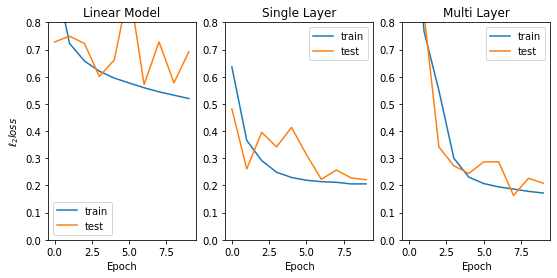

In [41]:
f, ax = plt.subplots(1,3,figsize=(9,4))
ax[0].plot(history_linear.history['loss'], label='train')
ax[0].plot(history_linear.history['val_loss'], label='test')
ax[0].set_ylim(0,0.8)
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel(r'$\ell_{2}loss$')
ax[0].set_title('Linear Model')
ax[1].plot(history_single.history['loss'], label='train')
ax[1].plot(history_single.history['val_loss'], label='test')
ax[1].set_ylim(0,0.8)
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_title('Single Layer')
ax[2].plot(history_multi.history['loss'], label='train')
ax[2].plot(history_multi.history['val_loss'], label='test')
ax[2].set_ylim(0,0.8)
ax[2].legend()
ax[2].set_xlabel('Epoch')
ax[2].set_title('Multi Layer')
#plt.tight_layout()
f.savefig('figs/LSTM_training_results.png')

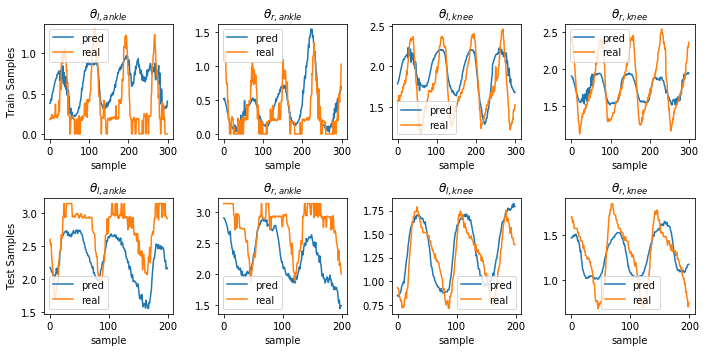

In [49]:
%matplotlib inline
from sklearn.metrics import mean_squared_error
y_test_pred = model_gait_multi.predict(X_test)
y_train_pred = model_gait_multi.predict(X_train)
mean_squared_error(y_test, y_test_pred)

f, ax = plt.subplots(2,4,figsize=(10,5))
# Train Plots
w = 300
ax[0][0].set_ylabel('Train Samples')
ax[0][0].plot(y_train_pred[:w,0])
ax[0][0].plot(y_train[:w,0])
ax[0][0].set_xlabel('sample')
ax[0][0].legend(['pred','real'])
ax[0][0].set_title(r'$\theta_{l,ankle}$')
ax[0][1].plot(y_train_pred[:w,1])
ax[0][1].plot(y_train[:w,1])
ax[0][1].set_xlabel('sample')
ax[0][1].legend(['pred','real'])
ax[0][1].set_title(r'$\theta_{r,ankle}$')
ax[0][2].plot(y_train_pred[:w,2])
ax[0][2].plot(y_train[:w,2])
ax[0][2].set_xlabel('sample')
ax[0][2].legend(['pred','real'])
ax[0][2].set_title(r'$\theta_{l,knee}$')
ax[0][3].plot(y_train_pred[:w,3])
ax[0][3].plot(y_train[:w,3])
ax[0][3].set_xlabel('sample')
ax[0][3].legend(['pred','real'])
ax[0][3].set_title(r'$\theta_{r,knee}$')
# Test Plots
w = 200
ax[1][0].set_ylabel('Test Samples')
ax[1][0].plot(y_test_pred[:w,0])
ax[1][0].plot(y_test[:w,0])
ax[1][0].set_xlabel('sample')
ax[1][0].legend(['pred','real'])
ax[1][0].set_title(r'$\theta_{l,ankle}$')
ax[1][1].plot(y_test_pred[:w,1])
ax[1][1].plot(y_test[:w,1])
ax[1][1].set_xlabel('sample')
ax[1][1].legend(['pred','real'])
ax[1][1].set_title(r'$\theta_{r,ankle}$')
ax[1][2].plot(y_test_pred[:w,2])
ax[1][2].plot(y_test[:w,2])
ax[1][2].set_xlabel('sample')
ax[1][2].legend(['pred','real'])
ax[1][2].set_title(r'$\theta_{l,knee}$')
ax[1][3].plot(y_test_pred[:w,3])
ax[1][3].plot(y_test[:w,3])
ax[1][3].set_xlabel('sample')
ax[1][3].legend(['pred','real'])
ax[1][3].set_title(r'$\theta_{r,knee}$')
plt.tight_layout()

Note the gif animations are in the extended version of this notebook [simple_base_refactor.ipynb]